# Custom ResNet-18

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
from pathlib import Path
import shutil
import os
import zipfile
import requests
from sklearn.metrics import confusion_matrix
import seaborn as sns
from itertools import product

In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.6 MB/s eta 0:00:00


In [ ]:
batch_size=128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#data augmentation - padding = 4, horizontal flip + normalization
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])


In [ ]:
def download_icubworld(dest_folder):

  url = 'http://www.icub.org/download/datasets/iCubWorld.zip'

  if not os.path.exists(dest_folder):
      os.makedirs(dest_folder)

  filename = os.path.join(dest_folder, url.split('/')[-1])

  response = requests.get(url, stream=True)
  total_size = int(response.headers.get('content-length', 0))

  with open(filename, 'wb') as file, tqdm(
      desc=filename,
      total=total_size,
      unit='B',
      unit_scale=True,
      unit_divisor=1024,
  ) as bar:
      for data in response.iter_content(1024):
          size = file.write(data)
          bar.update(size)

  return filename

def extract_zipfile(filepath, extract_to='./data'):
    with zipfile.ZipFile(filepath, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def flatten_icubworld_structure(src, dest):
    src = Path(src)
    dest = Path(dest)
    dest.mkdir(parents=True, exist_ok=True)

    for category_dir in src.iterdir():
        if not category_dir.is_dir():
            continue
        label = category_dir.name
        for object_dir in category_dir.iterdir():
            if not object_dir.is_dir():
                continue

            for ppm_file in object_dir.glob("*.ppm"):
                cls_dir = dest / cls_dir
                cls_dir.mkdir(exist_ok=True)
                new_filename = f"{object_dir.name}_{ppm_file.name}"
                shutil.copy(ppm_file, cls_dir / new_filename)


def flatten_test_categorization(src, dest):
    src = Path(src)
    dest = Path(dest)
    dest.mkdir(parents=True, exist_ok=True)

    for category_dir in src.iterdir():
        if not category_dir.is_dir() or category_dir.name == "mask":
            continue

        cls = category_dir.name
        cls_dir = dest / cls
        cls_dir.mkdir(exist_ok=True)

        for ppm_file in category_dir.glob("*.ppm"):
            shutil.copy(ppm_file, cls_dir / ppm_file.name)

def transform_icubworld():

  center_crop_60_percent = transforms.Lambda(lambda img: transforms.functional.crop(
    img,
    top=int(img.height * 0.2),
    left=int(img.width * 0.2),
    height=int(img.height * 0.6),
    width=int(img.width * 0.6)
  ))

  transform = transforms.Compose([
    center_crop_60_percent,
    transforms.ToTensor()

  ])

  trainset = torchvision.datasets.ImageFolder(root="./data/iCubWorld_flat/train", transform=transform)
  testset = torchvision.datasets.ImageFolder(root="./data/iCubWorld_flat/test_final", transform=transform)

  trainset, valset = random_split(trainset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
  testloader = DataLoader(testset, batch_size=batch_size)

  return trainset, valset, testset, trainloader, valloader, testloader


def get_icubworld_dataset():
  download_icubworld('./data')
  extract_zipfile('./data/iCubWorld.zip')
  flatten_icubworld_structure("./data/iCubWorld/train", "./data/iCubWorld_flat/train")
  flatten_test_categorization("./data/iCubWorld/test/categorization", "./data/iCubWorld_flat/test_final")
  trainset, valset, testset, trainloader, valloader, testloader = transform_icubworld()
  return trainset, testset, trainloader, testloader


In [ ]:
def get_cifar_dataset():

  #data augmentation - padding = 4, horizontal flip + normalization
  train_transform = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465),
                          (0.2023, 0.1994, 0.2010))
  ])

  test_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465),
                          (0.2023, 0.1994, 0.2010))
  ])


  transform = transforms.Compose([transforms.ToTensor()])

  trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
  testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

  trainset, valset = random_split(trainset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  valloader  = DataLoader(valset, batch_size=batch_size, shuffle=False)
  testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

  print(f"Training samples: {len(trainset)}, Test samples: {len(testset)}")

  return trainset, valset, testset, trainloader, valloader, testloader


In [ ]:
trainset, valset, testset, trainloader, valloader, testloader = get_cifar_dataset()

100%|██████████| 170M/170M [00:01<00:00, 106MB/s]


Training samples: 40000, Test samples: 10000


# ResNet Model Architecture

In [ ]:
class LayerBlock(nn.Module):
  def __init__(self, n_layers, in_channels, out_channels, init_stride, padding, kernel_size, use_residuals=False):
    super(LayerBlock, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.use_residuals = use_residuals

    self.layers = nn.ModuleList()
    self.one_one_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=init_stride)
    first_layer = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=init_stride),
      nn.BatchNorm2d(out_channels)
    )
    self.layers.append(first_layer)

    for i in range(2 * n_layers - 1):
      self.layers.append(nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding),
        nn.BatchNorm2d(out_channels)
      ))

  def forward(self, x):
    if self.use_residuals:
      i = 0
      while i < (len(self.layers)-1):
        l1 = self.layers[i]
        l2 = self.layers[i+1]
        out = l2(F.relu(l1(x)))

        if i == 0 and (self.in_channels != self.out_channels or self.one_one_conv.stride != (1, 1)):
          x = self.one_one_conv(x)

        x = F.relu(out + x)
        i += 2

      return x
    else:
      for layer in self.layers:
        x = F.relu(layer(x))
      return x

In [ ]:
class ResNet_Base(nn.Module):
  def __init__(self, n_layers=1, use_residuals=False):
    super(ResNet_Base, self).__init__()

    #feature map => 32
    #feature map => 16
    #feature map => 8
    self.conv1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),nn.BatchNorm2d(16))


    self.conv_block_16 = LayerBlock(n_layers, 16, 16, 1, 1, 3, use_residuals=use_residuals)
    self.conv_block_32 = LayerBlock(n_layers, 16, 32, 2, 1, 3, use_residuals=use_residuals)
    self.conv_block_64 = LayerBlock(n_layers, 32, 64, 2, 1, 3, use_residuals=use_residuals)

    self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.linear = nn.Linear(64, 10)


  def forward(self, image):

    image = F.relu(self.conv1(image))
    after_16_block = self.conv_block_16(image)
    after_32_block = self.conv_block_32(after_16_block)
    after_64_block = self.conv_block_64(after_32_block)

    avg_pooled = self.global_avg_pool(after_64_block)
    avg_pooled = avg_pooled.view(avg_pooled.size(0), -1)
    linear_output = self.linear(avg_pooled)

    return linear_output

In [ ]:
def train(model, optim, n_epochs, objective=F.cross_entropy, train_loader=trainloader):

  val_acc = []
  val_f1 = []
  train_acc = []
  train_f1 = []

  print(len(train_loader.dataset))

  for epoch in range(n_epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0

    all_preds = []
    all_labels = []

    for images, labels in train_loader:

      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = objective(output, labels)
      optim.zero_grad()
      loss.backward()
      optim.step()

      running_loss += loss.item()

      total += labels.shape[0]
      _, pred_indices = torch.max(output, dim=1)
      correct += (pred_indices == labels).sum().item()


      all_preds.extend(pred_indices.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    per_batch_loss = running_loss / len(train_loader)
    f1 = f1_score(all_labels, all_preds, average='macro')

    train_acc.append(accuracy)
    train_f1.append(f1)

    all_preds = []
    all_labels = []

    with torch.no_grad():
      model.eval()
      val_correct, val_total = 0, 0
      val_loss = 0.0
      for val_images, val_labels in valloader:
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_output = model(val_images)
        val_loss += objective(val_output, val_labels).item()

        val_total += val_labels.shape[0]
        _, val_pred_indices = torch.max(val_output, dim=1)
        val_correct += (val_pred_indices == val_labels).sum().item()

        all_preds.extend(val_pred_indices.cpu().numpy())
        all_labels.extend(val_labels.cpu().numpy())



      val_accuracy = val_correct / val_total
      val_loss = val_loss / len(valloader)

      f1 = f1_score(all_labels, all_preds, average='macro')
      val_acc.append(val_accuracy)
      val_f1.append(f1)

      if epoch % 10 == 0:
        print(f"Epoch :{epoch}/{n_epochs}, Train Loss: {per_batch_loss}, Train Accuracy: {accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Val f1: {f1}")


  return train_acc, train_f1, val_acc, val_f1, val_accuracy



In [ ]:

all_preds = []
all_labels = []

def evaluate(model):
  model.eval()
  correct, total = 0, 0
  with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Evaluating"):
      images, labels = images.to(device), labels.to(device)
      output = model(images)

      _, pred_indices = torch.max(output, dim=1)
      correct += (pred_indices == labels).sum().item()
      total += labels.shape[0]

      all_preds.extend(pred_indices.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  accuracy = correct / total
  print(f"Test Accuracy: {accuracy}")
  f1 = f1_score(all_labels, all_preds, average='macro')
  print(f"F1 Score: {f1:.4f}")
  return all_labels, all_preds

# Size = 8. Grid Search for LR and WD

In [ ]:
performance_map = {}

def objective(trial):

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

    cnn_model = ResNet_Base()
    cnn_model.to(device)

    optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_acc_list, train_f1_list, val_acc_list, val_f1_list, val_accuracy = train(cnn_model, optimizer, 20)
    plot_performance(train_acc_list, str(f'Training Accuracy. LR: {learning_rate:.5f}, WD: {weight_decay:.5f}'))

    performance_map[(learning_rate, weight_decay)] = val_accuracy

    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_params)
print(f'Performance Map: {performance_map}')

# Size=8. Training the Best Model on Complete Trainset
The best results were obtained in trial 12 for the following hyperparameter values. I will train this model on the entire dataset, for 100 epochs to get the best possible performance for this architecture. Then we will evaluate the model on the test dataset

learning_rate = 0.00191,
weight_decay = 0.00017

In [ ]:
learning_rate = 0.00191
weight_decay = 0.00017

combined_trainset = ConcatDataset([trainset, valset])
combined_trainloader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)
print(f"Training samples: {len(combined_trainset)}, Dataloader: {len(combined_trainloader.dataset)}")

cnn_model = ResNet_Base()
cnn_model.to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_acc_list, train_f1_list, val_acc_list, val_f1_list, val_accuracy = train(cnn_model, optimizer, 100, train_loader=combined_trainloader)
plot_performance(train_acc_list, str(f'Training Accuracy. LR: {learning_rate:.5f}, WD: {weight_decay:.5f}'))


Training samples: 50000, Dataloader: 50000
50000
Epoch :0/100, Train Loss: 1.4911683569173984, Train Accuracy: 0.44894, Val Loss: 1.2417290203178986, Val Accuracy: 0.5424, Val f1: 0.5202067937281638
Epoch :10/100, Train Loss: 0.6276667510609493, Train Accuracy: 0.78208, Val Loss: 0.6159289999853207, Val Accuracy: 0.7824, Val f1: 0.7798917525625437
Epoch :20/100, Train Loss: 0.521337967013459, Train Accuracy: 0.8202, Val Loss: 0.49582484251336206, Val Accuracy: 0.8261, Val f1: 0.8242137659907899
Epoch :30/100, Train Loss: 0.4773482373913231, Train Accuracy: 0.83334, Val Loss: 0.5129240604141091, Val Accuracy: 0.8229, Val f1: 0.8233911461773434
Epoch :40/100, Train Loss: 0.4501932085017719, Train Accuracy: 0.84474, Val Loss: 0.5178568034986907, Val Accuracy: 0.8193, Val f1: 0.8221107701886792
Epoch :50/100, Train Loss: 0.4265281255440334, Train Accuracy: 0.85182, Val Loss: 0.45234900901589215, Val Accuracy: 0.8436, Val f1: 0.8422370843896673
Epoch :60/100, Train Loss: 0.4173282753018772,

NameError: name 'plot_performance' is not defined

In [ ]:
evaluate(cnn_model)

Evaluating: 100%|██████████| 79/79 [00:02<00:00, 32.42it/s]


Test Accuracy: 0.8271
F1 Score: 0.8262


# Size = 14. Grid Search for LR and WD

In [ ]:
performance_map = {}

def objective(trial):

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

    cnn_model = ResNet_Base(n_layers=2)
    cnn_model.to(device)

    optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_acc_list, train_f1_list, val_acc_list, val_f1_list, val_accuracy = train(cnn_model, optimizer, 20)
    plot_performance(train_acc_list, str(f'Size = 14. Training Accuracy. LR: {learning_rate:.5f}, WD: {weight_decay:.5f}'))

    performance_map[(learning_rate, weight_decay)] = val_accuracy

    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_params)
print(f'Performance Map: {performance_map}')

# Training the Best Network on the whole Trainset. Size=14

Learning Rate: 0.00134,
Weight Decay: 0.0000341


Training samples: 50000, Dataloader: 50000
50000
Epoch :0/100, Train Loss: 1.5099781955904363, Train Accuracy: 0.44094, Val Loss: 1.2433670336687113, Val Accuracy: 0.5525, Val f1: 0.5474016397067641
Epoch :10/100, Train Loss: 0.5192184202811297, Train Accuracy: 0.82004, Val Loss: 0.5174929510943497, Val Accuracy: 0.814, Val f1: 0.813088839843864
Epoch :20/100, Train Loss: 0.38803805029758104, Train Accuracy: 0.86516, Val Loss: 0.3668846003239668, Val Accuracy: 0.8732, Val f1: 0.8726469900599797
Epoch :30/100, Train Loss: 0.3154476890935922, Train Accuracy: 0.88924, Val Loss: 0.31092497989346707, Val Accuracy: 0.8893, Val f1: 0.8892912208877798
Epoch :40/100, Train Loss: 0.271021868490502, Train Accuracy: 0.90454, Val Loss: 0.2832652417164815, Val Accuracy: 0.8948, Val f1: 0.8922882902810685
Epoch :50/100, Train Loss: 0.24029542747742075, Train Accuracy: 0.91566, Val Loss: 0.2104302839953688, Val Accuracy: 0.9267, Val f1: 0.9266559050889598
Epoch :60/100, Train Loss: 0.21296980146251981

<ipython-input-13-0e2ea4434791>:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize=10)


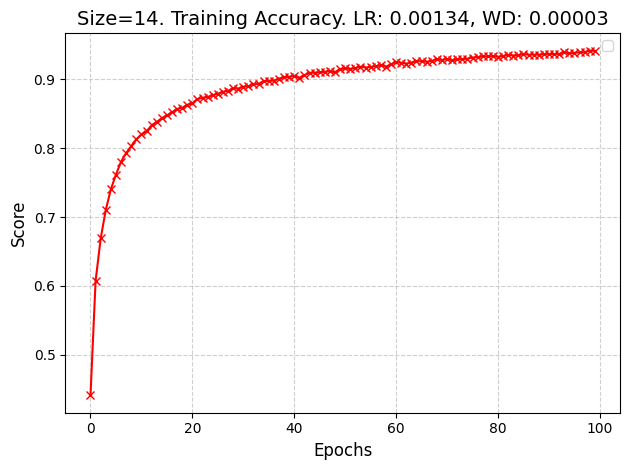

In [ ]:
learning_rate = 0.00134
weight_decay = 0.0000341

combined_trainset = ConcatDataset([trainset, valset])
combined_trainloader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)
print(f"Training samples: {len(combined_trainset)}, Dataloader: {len(combined_trainloader.dataset)}")

cnn_model = ResNet_Base(n_layers=2)
cnn_model.to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_acc_list, train_f1_list, val_acc_list, val_f1_list, val_accuracy = train(cnn_model, optimizer, 100, train_loader=combined_trainloader)
plot_performance(train_acc_list, str(f'Size=14. Training Accuracy. LR: {learning_rate:.5f}, WD: {weight_decay:.5f}'))


In [ ]:
evaluate(cnn_model)

Evaluating: 100%|██████████| 79/79 [00:02<00:00, 30.86it/s]

Test Accuracy: 0.8731
F1 Score: 0.8495


# Size=20. Grid Search for LR and WD

In [ ]:
performance_map = {}

def objective(trial):

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

    cnn_model = ResNet_Base(n_layers=3)
    cnn_model.to(device)

    optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_acc_list, train_f1_list, val_acc_list, val_f1_list, val_accuracy = train(cnn_model, optimizer, 20)
    plot_performance(train_acc_list, str(f'Size = 20. Training Accuracy. LR: {learning_rate:.5f}, WD: {weight_decay:.5f}'))

    performance_map[(learning_rate, weight_decay)] = val_accuracy

    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_params)
print(f'Performance Map: {performance_map}')

# Training the Best Network on the Complete Trainset. Size=20


Learning Rate: 0.00144
Weight Decay: 0.00007

Training samples: 50000, Dataloader: 50000
50000
Epoch :0/100, Train Loss: 1.7323252648648704, Train Accuracy: 0.33534, Val Loss: 1.572281175021884, Val Accuracy: 0.403, Val f1: 0.3813841386550751
Epoch :10/100, Train Loss: 0.582961933692093, Train Accuracy: 0.79846, Val Loss: 0.6052405802132208, Val Accuracy: 0.7854, Val f1: 0.7865487270939868
Epoch :20/100, Train Loss: 0.42469659760175155, Train Accuracy: 0.85372, Val Loss: 0.4210090823943102, Val Accuracy: 0.8532, Val f1: 0.8522106585177042
Epoch :30/100, Train Loss: 0.3514434147978683, Train Accuracy: 0.8785, Val Loss: 0.3495724023897437, Val Accuracy: 0.8775, Val f1: 0.8769353638342281
Epoch :40/100, Train Loss: 0.30562115489217023, Train Accuracy: 0.89362, Val Loss: 0.3192714778116987, Val Accuracy: 0.8857, Val f1: 0.88535477241968
Epoch :50/100, Train Loss: 0.2729059243217454, Train Accuracy: 0.90466, Val Loss: 0.3019776385796221, Val Accuracy: 0.8944, Val f1: 0.8948981303777523
Epoch :60/100, Train Loss: 0.24739286499788693, Tr

<ipython-input-14-0e2ea4434791>:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize=10)


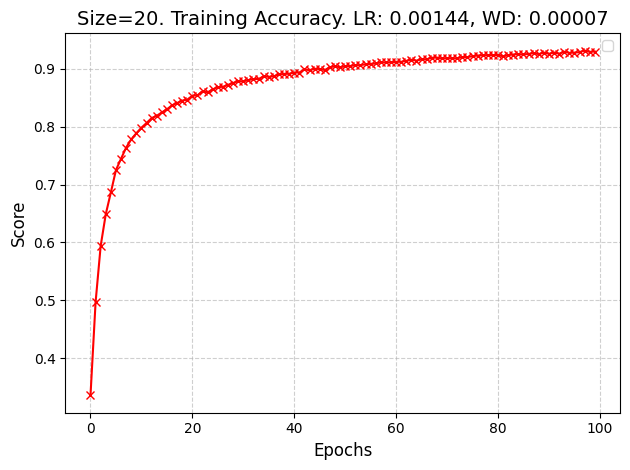

In [ ]:
learning_rate = 0.00144
weight_decay = 0.00007

combined_trainset = ConcatDataset([trainset, valset])
combined_trainloader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)
print(f"Training samples: {len(combined_trainset)}, Dataloader: {len(combined_trainloader.dataset)}")

cnn_model = ResNet_Base(n_layers=3)
cnn_model.to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_acc_list, train_f1_list, val_acc_list, val_f1_list, val_accuracy = train(cnn_model, optimizer, 100, train_loader=combined_trainloader)
plot_performance(train_acc_list, str(f'Size=20. Training Accuracy. LR: {learning_rate:.5f}, WD: {weight_decay:.5f}'))


In [ ]:
evaluate(cnn_model)

Evaluating: 100%|██████████| 79/79 [00:02<00:00, 27.48it/s]

Test Accuracy: 0.8606
F1 Score: 0.8619


# Residual Connections with Network Size = 14

Training samples: 50000, Dataloader: 50000
50000
Epoch :0/100, Train Loss: 1.4912355103151267, Train Accuracy: 0.44898, Val Loss: 1.1979177450831933, Val Accuracy: 0.5613, Val f1: 0.5438815573975304
Epoch :10/100, Train Loss: 0.4943724956049029, Train Accuracy: 0.82892, Val Loss: 0.4574753323310538, Val Accuracy: 0.8388, Val f1: 0.8370270593495416
Epoch :20/100, Train Loss: 0.36198857903023207, Train Accuracy: 0.87268, Val Loss: 0.33688775063315524, Val Accuracy: 0.8802, Val f1: 0.8789967334512818
Epoch :30/100, Train Loss: 0.3003009781050865, Train Accuracy: 0.89474, Val Loss: 0.30453388864480996, Val Accuracy: 0.8937, Val f1: 0.8923748711025358
Epoch :40/100, Train Loss: 0.25648262391767235, Train Accuracy: 0.9107, Val Loss: 0.24323791416385507, Val Accuracy: 0.914, Val f1: 0.9134555212135247
Epoch :50/100, Train Loss: 0.22960106077630196, Train Accuracy: 0.9192, Val Loss: 0.2655992081648187, Val Accuracy: 0.9026, Val f1: 0.9024096053631203
Epoch :60/100, Train Loss: 0.20533315050403

<ipython-input-15-0e2ea4434791>:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize=10)


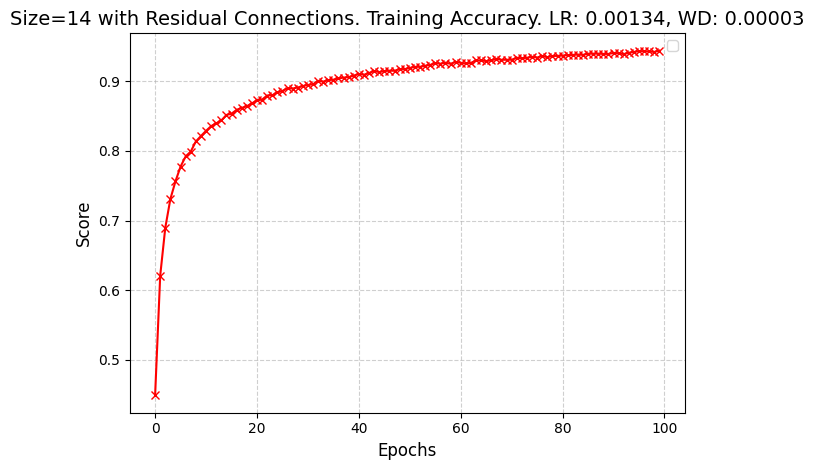

In [ ]:
learning_rate = 0.00134
weight_decay = 0.0000341

combined_trainset = ConcatDataset([trainset, valset])
combined_trainloader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)
print(f"Training samples: {len(combined_trainset)}, Dataloader: {len(combined_trainloader.dataset)}")

cnn_model = ResNet_Base(n_layers=2, use_residuals=True)
cnn_model.to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_acc_list, train_f1_list, val_acc_list, val_f1_list, val_accuracy = train(cnn_model, optimizer, 100, train_loader=combined_trainloader)
plot_performance(train_acc_list, str(f'Size=14 with Residual Connections. Training Accuracy. LR: {learning_rate:.5f}, WD: {weight_decay:.5f}'))


In [ ]:
evaluate(cnn_model)

Evaluating: 100%|██████████| 79/79 [00:02<00:00, 27.71it/s]

Test Accuracy: 0.8732
F1 Score: 0.8724


# Residual Connections with Network Size = 20

Training samples: 50000, Dataloader: 50000
50000
Epoch :0/100, Train Loss: 1.4299577509655672, Train Accuracy: 0.47102, Val Loss: 1.364442423929142, Val Accuracy: 0.5256, Val f1: 0.5036290628414899
Epoch :10/100, Train Loss: 0.4657215632288657, Train Accuracy: 0.83998, Val Loss: 0.45203070248229593, Val Accuracy: 0.843, Val f1: 0.842276344163348
Epoch :20/100, Train Loss: 0.3442842602120031, Train Accuracy: 0.8792, Val Loss: 0.3663502067704744, Val Accuracy: 0.871, Val f1: 0.8733617330258786
Epoch :30/100, Train Loss: 0.28279274930734466, Train Accuracy: 0.90134, Val Loss: 0.2735868281201471, Val Accuracy: 0.9027, Val f1: 0.9023091172379789
Epoch :40/100, Train Loss: 0.2473864313929587, Train Accuracy: 0.91382, Val Loss: 0.23776924336635613, Val Accuracy: 0.9154, Val f1: 0.915745505683865
Epoch :50/100, Train Loss: 0.22129402195324982, Train Accuracy: 0.92304, Val Loss: 0.22247021126596234, Val Accuracy: 0.9218, Val f1: 0.9214510642676277
Epoch :60/100, Train Loss: 0.2069388695270814, 

<ipython-input-15-0e2ea4434791>:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize=10)


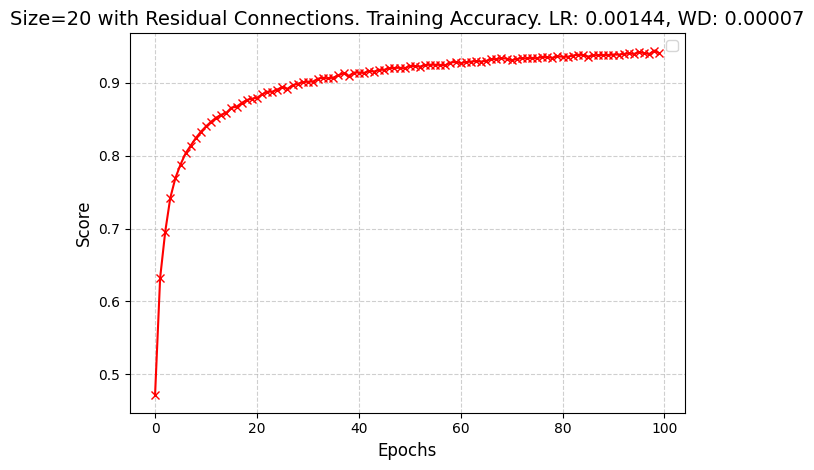

In [ ]:
learning_rate = 0.00144
weight_decay = 0.00007

combined_trainset = ConcatDataset([trainset, valset])
combined_trainloader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)
print(f"Training samples: {len(combined_trainset)}, Dataloader: {len(combined_trainloader.dataset)}")

cnn_model = ResNet_Base(n_layers=3, use_residuals=True)
cnn_model.to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_acc_list, train_f1_list, val_acc_list, val_f1_list, val_accuracy = train(cnn_model, optimizer, 100, train_loader=combined_trainloader)
plot_performance(train_acc_list, str(f'Size=20 with Residual Connections. Training Accuracy. LR: {learning_rate:.5f}, WD: {weight_decay:.5f}'))


In [ ]:
evaluate(cnn_model)

Evaluating: 100%|██████████| 79/79 [00:03<00:00, 26.16it/s]

Test Accuracy: 0.8804
F1 Score: 0.8766


# Grid Search on ICubWorld 1.0. Network Size = 20

In [ ]:
performance_map = {}

def objective(trial):

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

    cnn_model = ResNet_Base(n_layers=3, use_residuals=True)
    cnn_model.to(device)

    optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_acc_list, train_f1_list, val_acc_list, val_f1_list, val_accuracy = train(cnn_model, optimizer, 20)
    plot_performance(train_acc_list, str(f'ICubWorld 1.0. Size = 20. Training Accuracy. LR: {learning_rate:.5f}, WD: {weight_decay:.5f}'))

    performance_map[(learning_rate, weight_decay)] = val_accuracy

    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

print("Best hyperparameters:", study.best_params)
print(f'Performance Map: {performance_map}')

# Training Best iCubWorld Model on Complete Dataset. Size=20. With Residual Connections

Learning Rate : 0.0003071944502153078
Weight Decay: 2.6178378323033995e-05

Training samples: 6002, Dataloader: 6002
6002
Epoch :0/20, Train Loss: 1.5862040722623785, Train Accuracy: 0.5469843385538153, Val Loss: 2.229778003692627, Val Accuracy: 0.165, Val f1: 0.13837519875263724
Epoch :10/20, Train Loss: 0.03868292533653848, Train Accuracy: 0.9996667777407531, Val Loss: 0.12564852833747864, Val Accuracy: 0.9608333333333333, Val f1: 0.9578325547886252


<ipython-input-14-0e2ea4434791>:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize=10)


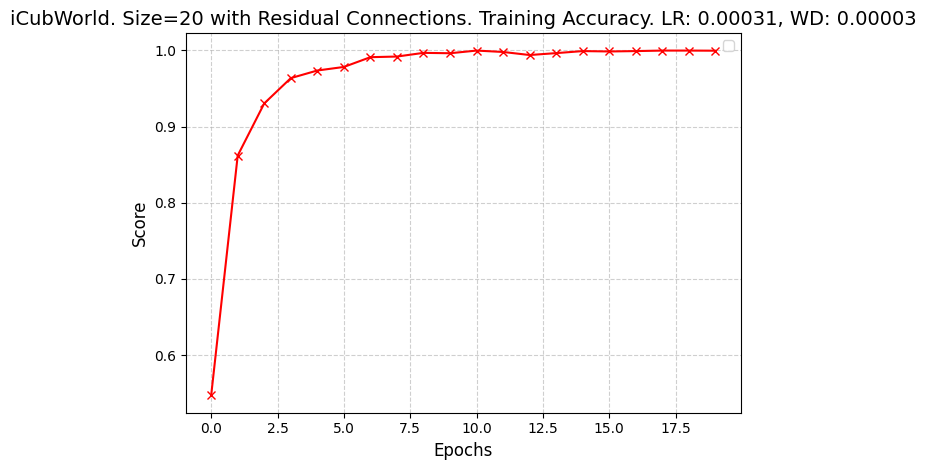

In [ ]:
learning_rate = 0.0003071944502153078
weight_decay = 2.6178378323033995e-05

combined_trainset = ConcatDataset([trainset, valset])
combined_trainloader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)
print(f"Training samples: {len(combined_trainset)}, Dataloader: {len(combined_trainloader.dataset)}")

cnn_model = ResNet_Base(n_layers=3, use_residuals=True)
cnn_model.to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_acc_list, train_f1_list, val_acc_list, val_f1_list, val_accuracy = train(cnn_model, optimizer, 20, train_loader=combined_trainloader)
plot_performance(train_acc_list, str(f'iCubWorld. Size=20 with Residual Connections. Training Accuracy. LR: {learning_rate:.5f}, WD: {weight_decay:.5f}'))


In [ ]:
all_preds, all_labels = evaluate(cnn_model)

Evaluating: 100%|██████████| 16/16 [00:01<00:00, 10.38it/s]

Test Accuracy: 0.7966016991504248
F1 Score: 0.7676


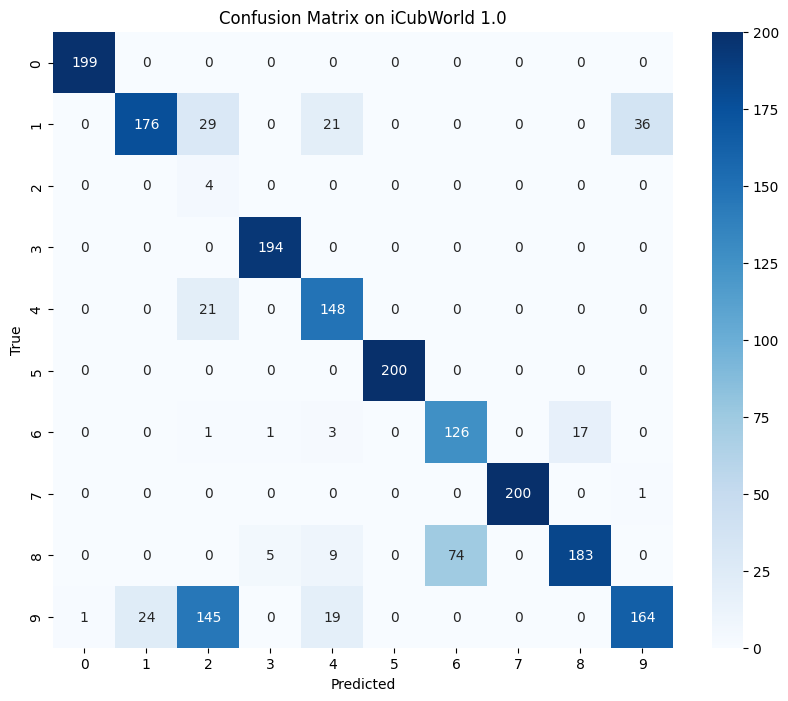

In [ ]:
class_names = [i for i in range(10)]

cm = confusion_matrix(all_labels, all_preds, labels=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on iCubWorld 1.0')
plt.show()

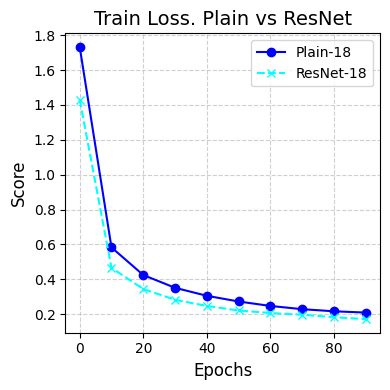

In [ ]:

train_loss_14_plain = [1.5099781955904363, 0.5192184202811297, 0.38803805029758104, 0.3154476890935922, 0.271021868490502, 0.24029542747742075, 0.21296980146251981, 0.1993248293657437, 0.18797851096638632, 0.1767658756478973]
train_loss_20_plain = [1.7323252648648704, 0.582961933692093, 0.42469659760175155, 0.3514434147978683, 0.30562115489217023, 0.2729059243217454, 0.24739286499788693, 0.22887255563912795, 0.21670191771234087, 0.20934306999758992]
train_loss_14_resnet = [1.4912355103151267, 0.4943724956049029, 0.36198857903023207, 0.3003009781050865, 0.25648262391767235, 0.22960106077630196, 0.20533315050403786, 0.19300919256704238, 0.1758323566764212, 0.16572588155298587]
train_loss_20_resnet = [1.4299577509655672, 0.4657215632288657, 0.3442842602120031, 0.28279274930734466, 0.2473864313929587, 0.22129402195324982, 0.2069388695270814, 0.1971168888308813, 0.18278691902413696, 0.17187844214918058]
x = [ i*10 for i in range(0, len(train_loss_20_resnet))]
plot_performance(x, None, "Train Loss. Plain vs ResNet", None, train_loss_20_plain, train_loss_20_resnet)